In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats
from tqdm import tqdm  # Progress bar

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler  # Standardizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # One hot Encoder
from scipy.sparse import csr_matrix  # For sparse matrix

from sklearn.model_selection import train_test_split
# Different Models
from sklearn.linear_model import LogisticRegression, SGDClassifier  # LR
from sklearn.svm import LinearSVC  # SVM
from sklearn.tree import DecisionTreeClassifier  #DT
from sklearn.ensemble import RandomForestClassifier  # RF
import xgboost as xgb  #XGB

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer  # Scoring functions
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  # Scoring fns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Cross validation
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

from sklearn import metrics
%matplotlib inline

In [2]:
file_path = "./datasets/final_UNSW-NB15"
# Train and Test data
x_train, y_train = pickle.load(open(file_path+'/final_train.pkl', 'rb'))
x_test, y_test = pickle.load(open(file_path+'/final_test.pkl', 'rb'))

# Dictionaries
saved_dict = pickle.load(open(file_path+'/saved_dict.pkl', 'rb'))
mode_dict = pickle.load(open(file_path+'/mode_dict.pkl', 'rb'))

# Standard scaler
scaler = pickle.load(open(file_path+'/scaler.pkl', 'rb'))

# Onehot encoders
ohe_proto = pickle.load(open(file_path+'/ohe_proto.pkl', 'rb'))
ohe_service = pickle.load(open(file_path+'/ohe_service.pkl', 'rb'))
ohe_state = pickle.load(open(file_path+'/ohe_state.pkl', 'rb'))

label_encoder = pickle.load(open(file_path+'/label_encoder.pkl', 'rb'))


## Pipeline functions

In [3]:
#------------------------------------------------------------------------------------------
# Data Cleaning
#------------------------------------------------------------------------------------------
def clean_data(data):
    '''
    Cleans given raw data. Performs various cleaning, removes Null and wrong values.
    Check for columns datatype and fix them.
    '''
    numerical_col = data.select_dtypes(include=np.number).columns  # All the numerical columns list
    categorical_col = data.select_dtypes(exclude=np.number).columns  # All the categorical columns list
    
    # Cleaning the data
    for col in data.columns:
        val = mode_dict[col]  # Mode value of the column in train data
        data[col] = data[col].fillna(value=val)
        data[col] = data[col].replace(' ', value=val)
        data[col] = data[col].apply(lambda x:"none" if x=="-" else x)

        # Fixing binary columns
        if col in saved_dict['binary_col']:
            data[col] = np.where(data[col]>1, val, data[col])

    # Fixing datatype of columns
    bad_dtypes = list(set(categorical_col) - set(saved_dict['cat_col']))
    for bad_col in bad_dtypes:
        data[col] = data[col].astype(float)
    
    return data

#------------------------------------------------------------------------------------------
# Feature Engineering: Apply log1p
#------------------------------------------------------------------------------------------
def apply_log1p(data):
    '''
    Performs FE on the data. Apply log1p on the specified columns create new column and remove those original columns.
    '''
    for col in saved_dict['log1p_col']:
        new_col = col + '_log1p'  # New col name
        data[new_col] = data[col].apply(np.log1p)  # Creating new column on transformed data
        data.drop(col, axis=1, inplace=True)  # Removing old columns
    return data

#------------------------------------------------------------------------------------------
# Standardizing: Mean centering an d varience scaling
#------------------------------------------------------------------------------------------
def standardize(data):
    '''
    Stanardize the given data. Performs mean centering and varience scaling.
    Using stanardscaler object trained on train data.
    '''
    data[saved_dict['num_col']] = scaler.transform(data[saved_dict['num_col']])
    return data

#------------------------------------------------------------------------------------------
# Onehot encoding of categorical columns
#------------------------------------------------------------------------------------------
def ohencoding(data):
    '''
    Onehot encoding the categoricla columns.
    Add the ohe columns with the data and removes categorical columns.
    Using Onehotencoder objects trained on train data.
    '''
    # Onehot encoding cat col using onehotencoder objects
    X = ohe_service.transform(data['service'].values.reshape(-1, 1))
    Xm = ohe_proto.transform(data['proto'].values.reshape(-1, 1))
    Xmm = ohe_state.transform(data['state'].values.reshape(-1, 1))
    
    # Adding encoding data to original data
    data = pd.concat([data,
                      pd.DataFrame(Xm.toarray(), columns=['proto_'+i for i in ohe_proto.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in ohe_service.categories_[0]]),
                      pd.DataFrame(Xmm.toarray(), columns=['state_'+i for i in ohe_state.categories_[0]])],
                      axis=1)
    
    # Removing cat columns
    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)
    return data

In [4]:
def labelcoding(data):
    data= label_encoder.transform(data) 
    return data

In [5]:
def get_final_data(data, saved_dict=saved_dict, mode_dict=mode_dict):
    '''
    This functions takes raw input and convert that to model required output.
    '''
    data.reset_index(drop=True, inplace=True)
    data.columns = saved_dict['columns']
    
    data['network_bytes'] = data['dbytes'] + data['sbytes']
    
    dropable_col = saved_dict['to_drop'] + saved_dict['corr_col']
    data.drop(columns=dropable_col, inplace=True)
    
    data = clean_data(data)
    data = apply_log1p(data)
    data = standardize(data)
    data = ohencoding(data)
    
    return data

In [6]:
x_test.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'label'],
      dtype='object')

In [7]:
ohe_service.categories_

[array(['dhcp', 'dns', 'ftp', 'ftp-data', 'http', 'irc', 'none', 'pop3',
        'radius', 'smtp', 'snmp', 'ssh', 'ssl'], dtype=object)]

In [8]:
# Using pipeline to prepare test data
x_test = get_final_data(x_test)

In [9]:
y_test=y_test.fillna(value="normal").apply(lambda x:x.strip().lower())
y_test = y_test.replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())
y_test= labelcoding(y_test)
y_test = pd.DataFrame(y_test,columns=['attack_cat',],)
y_test=y_test['attack_cat']

In [10]:
y_test.unique()

array([6, 3, 5, 4, 7, 2, 0, 1, 8, 9])

In [11]:
x_train.shape, y_train.shape

((1778032, 197), (1778032,))

In [12]:
x_test.shape, y_test.shape

((762015, 197), (762015,))

In [13]:
all(x_train.columns == x_test.columns)

True

In [64]:

def encode_attack_non_attack(df):
    #something broke, so i'm doing this, i'm tired
    df=pd.DataFrame(df)
    replace_values = [9, 8, 7, 5, 4, 3, 2, 1, 0]
    new_df = df.replace(replace_values, 1).replace(6, 0)
    return new_df

def false_alarm_rate(y_true, y_pred):
    """
    This function will return False Alarm Rate for given true and predicted values.
    False Alarm Rate is average of False Negetive Rate and False Positive Rate
    """
    y_true=encode_attack_non_attack(y_true)
    y_pred = encode_attack_non_attack(y_pred)

    c_matrix=confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = c_matrix.ravel()
    
    labels= ['non-attack', 'attack']
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.heatmap(c_matrix, annot=True, cmap='Blues', fmt='d',xticklabels=labels, yticklabels=labels)  # Customize colors and format
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for General Attack Detection')
    plt.show()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm rate


def evaluate_result(y_test, y_test_predictions, model_name):

    # Training the model (assuming you already have the trained model)
    # clf.fit(x_train, y_train)  # Remove this line if training is done elsewhere
    
    # Prediction on test data
    
    # F1 score and acc score
    far=false_alarm_rate(y_test, y_test_predictions)
    # test_f1 = f1_score(y_test, y_test_pred, average=None)
    acc = accuracy_score(y_test, y_test_predictions)
    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    
    x = PrettyTable()
    x.field_names = [ 'Accuracy','False Alarm Rate']
    x.add_row([acc,far])
    print(x)

    confusion_matrix = metrics.confusion_matrix(y_test, y_test_predictions)

    # Create a heatmap with clear labels and annotations
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')  # Customize colors and format
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    # cm_display.plot()
    # plt.show()
    
    # Returning scores
    return acc

## Logistic Regression


In [15]:
import numpy
from sklearn import linear_model

#Reshaped for Logistic function.
# X = numpy.array([3.78, 2.44, 2.09, 0.14, 1.72, 1.65, 4.92, 4.37, 4.96, 4.52, 3.69, 5.88]).reshape(-1,1)
# y = numpy.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

logr = linear_model.LogisticRegression()
logr.fit(x_train,y_train)

#predict if tumor is cancerous where the size is 3.46mm:
# predicted = logr.predict(numpy.array([3.46]).reshape(-1,1))
# print(predicted) 

LogisticRegression()

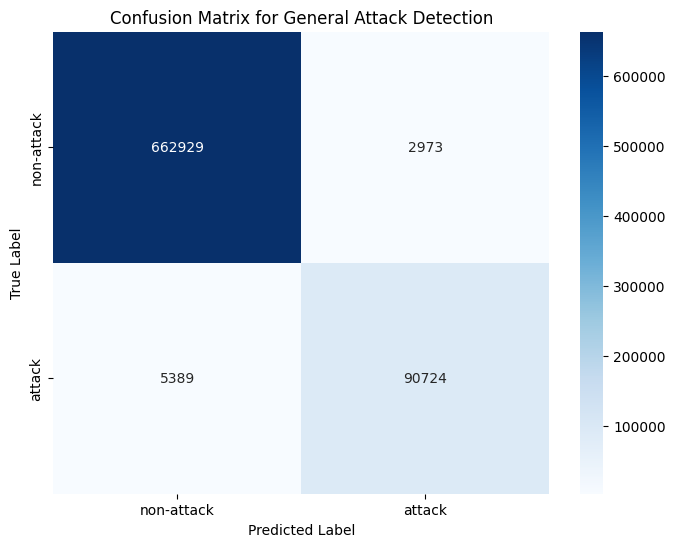

+--------------------+---------------------+
|      Accuracy      |   False Alarm Rate  |
+--------------------+---------------------+
| 0.9738955269909385 | 0.03026701960454229 |
+--------------------+---------------------+


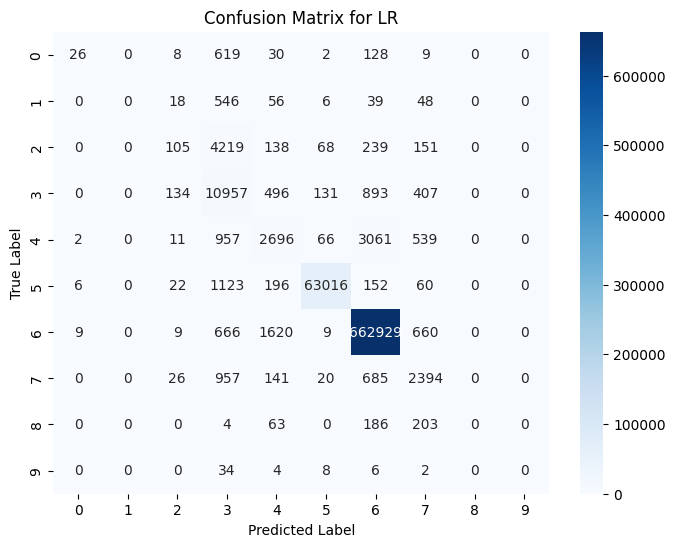

In [54]:
lr_y_test_pred = logr.predict(x_test)
lr_acc =evaluate_result(y_test, lr_y_test_pred, 'LR')

In [55]:
with open('datasets/final_UNSW-NB15/my_lr.pkl', 'wb') as f:
    pickle.dump(logr, f)

## Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)
rf_clf = RandomForestClassifier(max_depth=22, random_state=0)
rf_clf.fit(x_train,y_train)

RandomForestClassifier(max_depth=22, random_state=0)

In [57]:
rf_y_test_pred=rf_clf.predict(x_test)

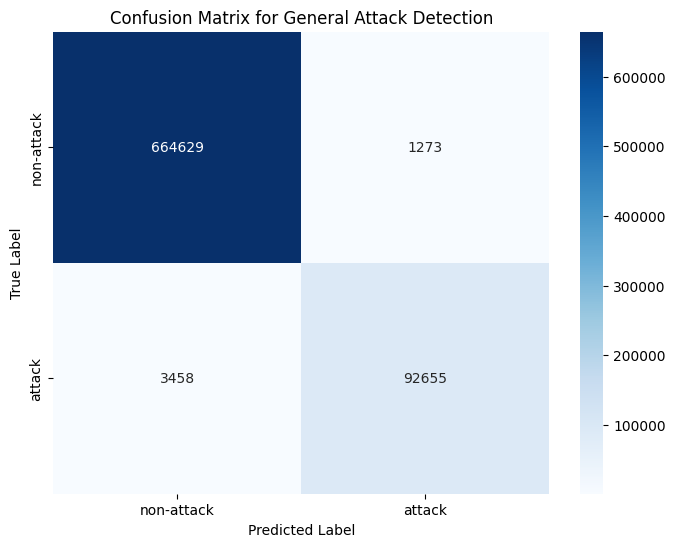

+-------------------+----------------------+
|      Accuracy     |   False Alarm Rate   |
+-------------------+----------------------+
| 0.981186722046154 | 0.018945088185699423 |
+-------------------+----------------------+


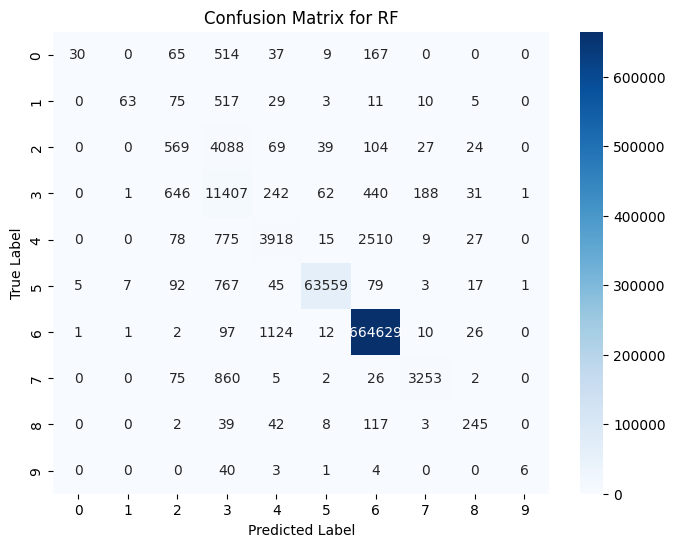

In [58]:
lr_acc =evaluate_result(y_test, rf_y_test_pred, 'RF')

In [59]:
with open('datasets/final_UNSW-NB15/my_rf.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

## XGBBoost

In [65]:
from xgboost import XGBClassifier
# read data
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# data = load_iris()
# X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.2)
# create model instance
bst = XGBClassifier(n_estimators=400, max_depth=12, learning_rate=0.1, colsample_bylevel=0.5, subsample=0.1, n_jobs=-1)
# fit model
bst.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [66]:
xgb_y_test_pred=bst.predict(x_test)

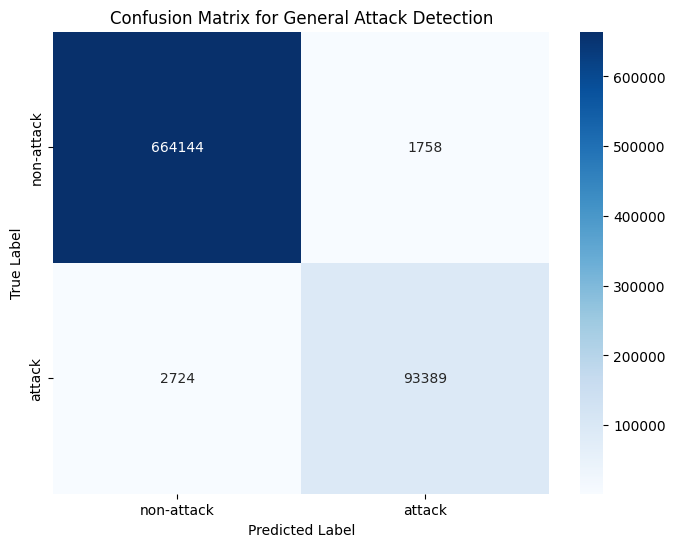

+--------------------+---------------------+
|      Accuracy      |   False Alarm Rate  |
+--------------------+---------------------+
| 0.9808284613819938 | 0.01549083382035822 |
+--------------------+---------------------+


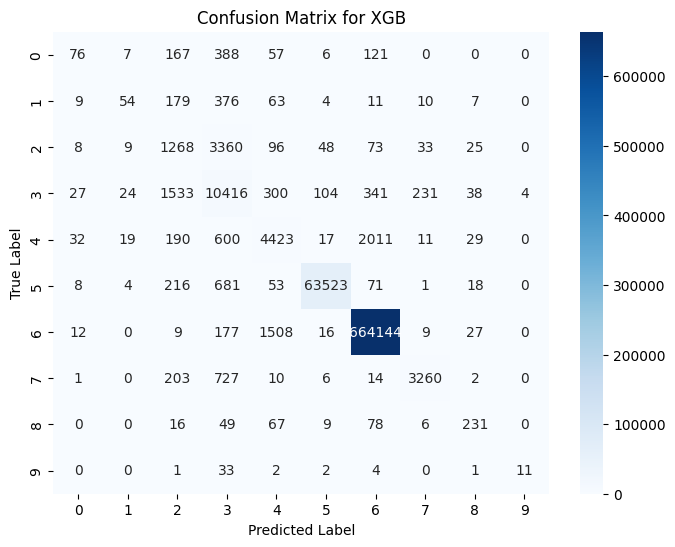

In [67]:
xgb_acc =evaluate_result(y_test, xgb_y_test_pred, 'XGB')

In [68]:
with open('datasets/final_UNSW-NB15/my_xgb.pkl', 'wb') as f:
    pickle.dump(bst, f)

## Ensemble

In [69]:
from sklearn.ensemble import VotingClassifier
# Initializing all the 3 classifiers with best found parameters
dt_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=6, min_samples_leaf=9)
rf_clf = RandomForestClassifier(criterion='gini', max_depth=22, min_samples_split=6, n_estimators=300, n_jobs=-1)
xgb_clf = xgb.XGBClassifier(n_estimators=400, max_depth=12, learning_rate=0.1, colsample_bylevel=0.5, subsample=0.1, n_jobs=-1)
v_clf = VotingClassifier(estimators=[('lr', dt_clf), ('rf', rf_clf), ('xgb', xgb_clf)], voting='soft', n_jobs=-1)

In [70]:
v_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=9,
                                                     min_samples_split=6)),
                             ('rf',
                              RandomForestClassifier(max_depth=22,
                                                     min_samples_split=6,
                                                     n_estimators=300,
                                                     n_jobs=-1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=0.5,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            earl...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=12,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 n_jobs=-1, voting='soft')

In [71]:
v_clf_y_test_pred=v_clf.predict(x_test)

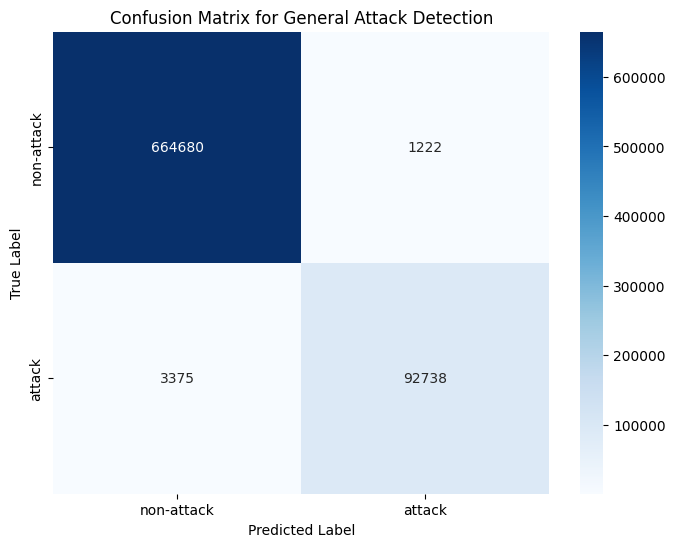

+--------------------+----------------------+
|      Accuracy      |   False Alarm Rate   |
+--------------------+----------------------+
| 0.9813796316345479 | 0.018475010840972098 |
+--------------------+----------------------+


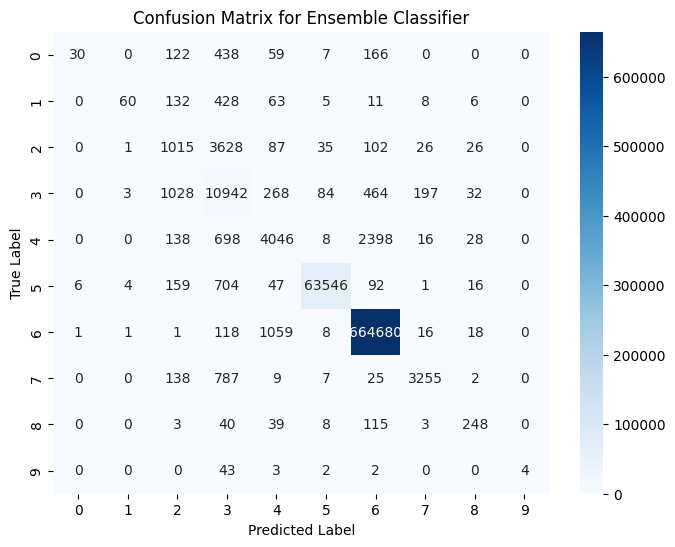

In [72]:
v_clf_acc =evaluate_result(y_test, v_clf_y_test_pred, 'Ensemble Classifier')

In [73]:
with open('datasets/final_UNSW-NB15/my_ensemble_clf.pkl', 'wb') as f:
    pickle.dump(v_clf, f)